<a href="https://colab.research.google.com/github/smerinobluewin/hello-world/blob/master/brown_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[[1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000. 1000000.
  1000000. 1000000.]]
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
DATA=array([[ 1.e+06,  1.e+06,  1.e+06, ...,  1.e+06,  1.e+06,  1.e+06],
       [-1.e+00, -1.e+00, -1.e+00, ..., -1.e+00, -1.e+00, -1.e+00],
       [-1.e+00, -1.e+00, -1.e+00, ..., -1.e+00, -1.e+00, -1.e+00],
       ...,
       [-1.e+00, -1.e+00, -1.e+00, ..., -1.e+00, -1.e+00, -1.e+00],
       [-1.e+00, -1.e+00, -1.e+00, ..., -1.e+00, -1.e+00, -1.e+00],
       [-1.e+00, -1.e+00, -1.e+00, ..., -1.e+00, -1.e+00, -1.e+00]])
[[ 1.05170191  0.24165189 -1.07988117  0.96418017 -0.21192344  0.78741741
   0.24526599 -0.76202503 -1.91209048 -0.74912566]]
[[1006823.51202969 1001720.67655051  993395.80075758 1006272.17684676
   998863.42048255 1005158.67611824 1001743.44321222  995398.10621437
   988153.37482459  

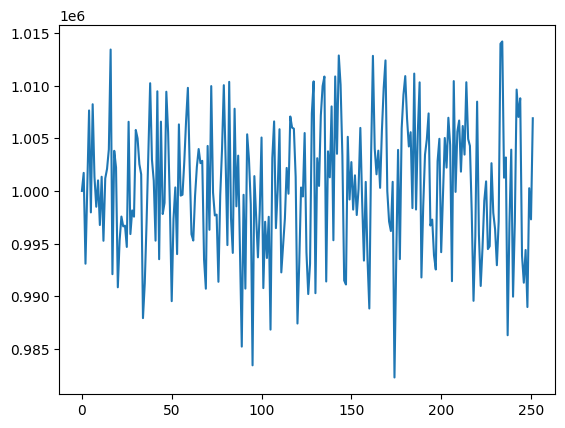

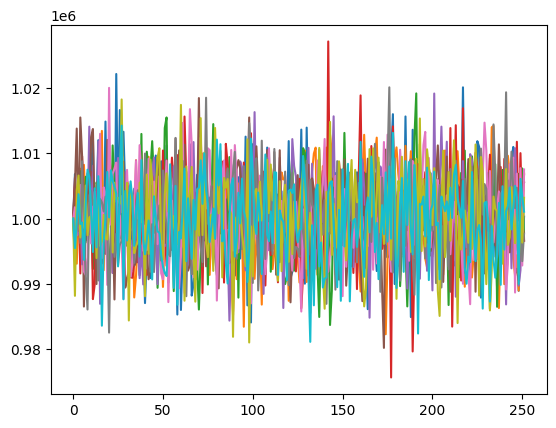

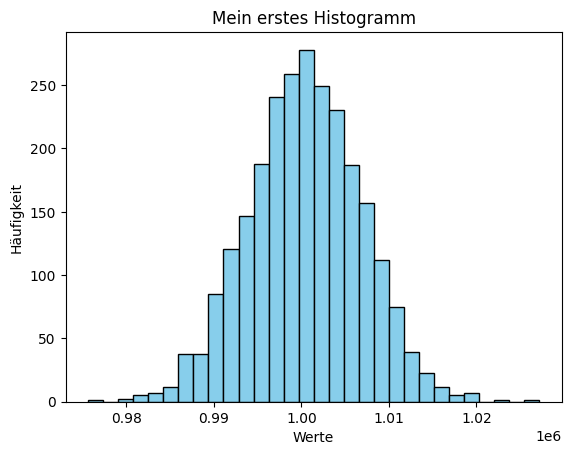

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt






mu=0.05
sigma=2*mu
S1=1000000
C=0
Npath=10                      # number of simulation paths
N= 252                         # number of time steps (days)
dt=1/252                      # 252 trading days
S1=S1*np.ones((1, Npath))  # initialize row vector of length Npath to build matrix of paths
S1=np.round(S1,0)
#print(S1)
DATA=-1*np.ones((N,Npath))    # initialize matrix of paths with Npath scenarios of time length N
#print(DATA)
# St=np.array([S1], dtype=np.float32)

DATA[0, :] = S1
#print(f"{DATA=}")

for number in range(1,N):
  #print(number)
  rng=np.random.default_rng()
  eps=rng.standard_normal((1, Npath)) # Note the tuple for dimensions
  print(eps)
  #eps=random.normalvariate(mu=0,sigma=1)
  S=S1+S1*(mu*dt+sigma*eps*np.sqrt(dt)) - C*dt
  #print(S)
  DATA[number, :] = S
  #St=np.column_stack((St,S))

DATA=np.round(DATA,0)
#print(DATA)
#print(f"{DATA=}")
#print(St[1:10])
#print(St[-1])

data=DATA.flatten()
#print(data[1:11])

# Analogous to plot(x) in MATLAB
plt.plot(DATA[:,1])
plt.show()

plt.plot(DATA)
plt.show()



#plt.hist(data, bins=30, color='skyblue', edgecolor='black')
#plt.title("Mein erstes Histogramm")
#plt.xlabel("Werte")
#plt.ylabel("Häufigkeit")
#plt.show()


